# Navigation - Basic DQN

---

In this notebook, I implemented a basic DQN based on Udacity's "Deep_Q_Network_Solution.ipynb" with the following additions:
* Double DQN
* Used Non-linear layers on the 3 first layers of the NN
* NON-Prioritised Experience Replay
(Please read the README.MD for full references)

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
from datetime import datetime
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#### 1.1 Import from the python files developed for this project
You'll find all the python code in this files.
* dqn_agent.py: Define Agent class
* model.py:     Define the DQN NN


In [3]:
from dqn_agent import Agent

### 2. Define the arguments that we will use

This is a comprehensive list of arguments that will serve as a fundation for the both, this initial project and the most advanced Visual Banana project with the eyes set on future ATARI games. You'll notice that many of these parameters are not used here (but are on the Visual Banana project). You'll also notice that I created a class rather than using "argparse", and the reason is that I had issues running "argparse" on a Jupyter Notebook environment. 

In [14]:
class args:
    seed = 123                      # Random seed
    use_NoisyNet = True             # Use Noisy Net or (if False) use standard linear layer on the NN
    disable_cuda = False            # Disable CUDA
    device = torch.device('cuda')   # CUDA (GPU) or CPU
    game = '/home/munirjojo-verge/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64' # Udacity environment. In the future an ATARI game        
    T_max = int(1e3)                # Number of training steps (4x number of frames)
    max_episode_length = int(108e3) # Max episode length (0 to disable)
    history_length = 1              # Number of consecutive states processed
    hidden_size = 64                # Network hidden size
    noisy_std = 0.1                 # Initial standard deviation of noisy linear layers
    atoms = 51                      # Discretised size of value distribution
    V_min = -10                     # Minimum of value distribution support
    V_max = 10                      # Maximum of value distribution support
    model = ''                      # Pretrained model (state dict)
    memory_capacity = int(1e5)      # Experience replay memory capacity
    replay_frequency = 1            # Frequency of sampling from memory
    priority_exponent = 0.5         # Prioritised experience replay exponent (originally denoted α)
    priority_weight = 0.4           # Initial prioritised experience replay importance sampling weight
    multi_step = 1                  # Number of steps for multi-step return
    discount = 0.99                 # GAMMA Discount factor
    target_update = int(4)          # Number of steps after which to update target network
    tau = 1e-3                      # for soft update of target network parameters (θ_target = τ*θ_local + (1 - τ)*θ_target)
    reward_clip = 1                 # Reward clipping (0 to disable)
    lr = 0.000625                   # Learning rate
    adam_eps = 1.5e-4               # Adam epsilon
    batch_size = 64                 # Batch size
    learn_start = int(80e1)         # Number of steps before starting training
    evaluate = False                # Evaluate only
    evaluation_interval = 100000    # Number of training steps between evaluations
    evaluation_episodes = 10        # Number of evaluation episodes to average over
    evaluation_size = 500           # Number of experiences (replay memory) to use for validating Q
    log_interval = 25000            # Number of training steps between printing logging status
    render = False                  # Display screen (testing only)

### 3. Setup the platform where we'll run

Using some of the arguments above we can setup some of our platform parameters

In [15]:
random.seed(args.seed)
torch.manual_seed(random.randint(1, 10000))

# Setup the device we will use.
if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  torch.cuda.manual_seed(random.randint(1, 10000))
  torch.backends.cudnn.enabled = False  # Disable nondeterministic ops (not sure if critical but better safe than sorry)
else:
  args.device = torch.device('cpu')

# Print all these parameters for Reference
print('Agent Parameters')
print('********************************************************************************')
for k, v in vars(args).items():
  print(k + ': ' + str(v))

Agent Parameters
********************************************************************************
__module__: __main__
seed: 123
use_NoisyNet: True
disable_cuda: False
device: cuda
game: /home/munirjojo-verge/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64
T_max: 1000
max_episode_length: 108000
history_length: 1
hidden_size: 64
noisy_std: 0.1
atoms: 51
V_min: -10
V_max: 10
model: 
memory_capacity: 100000
replay_frequency: 1
priority_exponent: 0.5
priority_weight: 0.4
multi_step: 1
discount: 0.99
target_update: 4
tau: 0.001
reward_clip: 1
lr: 0.000625
adam_eps: 0.00015
batch_size: 64
learn_start: 800
evaluate: False
evaluation_interval: 100000
evaluation_episodes: 10
evaluation_size: 500
log_interval: 25000
render: False
__dict__: <attribute '__dict__' of 'args' objects>
__weakref__: <attribute '__weakref__' of 'args' objects>
__doc__: None


### 4. Simple ISO 8601 timestamped logger

In [16]:
def log(s):
  print('[' + str(datetime.now().strftime('%Y-%m-%dT%H:%M:%S')) + '] ' + s)

### 5. Create the Environment - Unity

In [7]:
env = UnityEnvironment(file_name=args.game)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [17]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 6. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [18]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.07860738 0.
 1.         0.         0.         0.50129277 0.         0.
 1.         0.         0.30833051 0.         1.         0.
 0.         0.48348328 0.         0.         1.         0.
 0.31010503 0.         1.         0.         0.         0.45606101
 1.         0.         0.         0.         0.26868555 0.
 0.        ]
States have length: 37


### 7. Setup the Agent (i.e. define the DQN)

In [19]:
# Construct the Agent with it's brain(DQN, DDQN, and the Replay Memory withOUT weighted priorities)
agent = Agent(args=args, state_size=state_size, action_size=action_size)

### 8. Train the Agent with DQN

DQN Basic train function

In [22]:
from __future__ import print_function

def dqn(n_episodes=2000, max_t=2000, eps_start=0.4, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    f1=open('./TraningSummary_'+ str(datetime.now().strftime('%Y_%m_%dT_%H_%M')), 'w+')
    
    scores = []                                        # list containing scores from each episode
    scores_window = deque(maxlen=100)                  # last 100 scores
    eps = eps_start                                    # initialize epsilon
    test_passed = False
    highest_avg_score = 0
    
    # Training loop    
    print('Training loop')  
    print('\rNum episodes: {}\tmax_t: {}\teps_start: {:.3f}\teps_end: {:.3f}\teps_decay: {:.3f}'.format(n_episodes, max_t, eps_start, eps_end, eps_decay))
    
    print('Training loop', file=f1)
    print('\rNum episodes: {}\tmax_t: {}\teps_start: {:.3f}\teps_end: {:.3f}\teps_decay: {:.3f}'.format(n_episodes, max_t, eps_start, eps_end, eps_decay), file=f1)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score          
        done = False
        for t in range(max_t):
    
            if args.use_NoisyNet and t % args.replay_frequency == 0:
              agent.reset_noise()                          # Draw a new set of noisy weights

            action = agent.act(state, eps)                 # Choose an action greedily (with noisy weights)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward        
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score

            agent.step(state, action, reward, next_state, done) # Have the agent update all the information from this experience

            state = next_state

            if args.reward_clip > 0:
              reward = max(min(reward, args.reward_clip), -args.reward_clip)  # Clip rewards
            
            if done:                
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        avg_score = np.mean(scores_window)# average score for the last 100 episodes
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        # Print every episode score and the last 100 episodes average score
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, avg_score), end="")
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, avg_score), file=f1)
        
        if i_episode % 10 == 0:
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, avg_score))
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, avg_score), file=f1)
            
        # Handleling the PASS Criteria        
        if avg_score >= 13.0 and not test_passed:
            test_passed = True            
            torch.save(agent.DQN_local.state_dict(), 'checkpoint_JustPass.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, avg_score))
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, avg_score),file=f1)
            
        # Let's see how good we can get..and continue!
        if highest_avg_score < avg_score:
            highest_avg_score = avg_score
            torch.save(agent.DQN_local.state_dict(), 'checkpoint_Best.pth')
        
    f1.close()        
    return scores     


Run the code cell below to train the agent from scratch.
Alternatively, you can skip to the next step below (**9. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

Training loop
Num episodes: 2000	max_t: 2000	eps_start: 0.400	eps_end: 0.010	eps_decay: 0.995
Episode 10	Score: 9.00	Average Score: 7.40
Episode 20	Score: 3.00	Average Score: 7.659
Episode 30	Score: 11.00	Average Score: 8.23
Episode 40	Score: 11.00	Average Score: 8.47
Episode 50	Score: 11.00	Average Score: 8.86
Episode 60	Score: 15.00	Average Score: 9.27
Episode 70	Score: 10.00	Average Score: 9.61
Episode 80	Score: 12.00	Average Score: 9.81
Episode 90	Score: 9.00	Average Score: 9.687
Episode 100	Score: 9.00	Average Score: 9.71
Episode 110	Score: 7.00	Average Score: 10.191
Episode 120	Score: 13.00	Average Score: 10.73
Episode 130	Score: 16.00	Average Score: 11.17
Episode 140	Score: 18.00	Average Score: 11.43
Episode 150	Score: 15.00	Average Score: 11.63
Episode 160	Score: 11.00	Average Score: 11.59
Episode 170	Score: 11.00	Average Score: 11.61
Episode 180	Score: 8.00	Average Score: 11.704
Episode 190	Score: 14.00	Average Score: 12.14
Episode 200	Score: 2.00	Average Score: 12.063
Episode

Episode 1730	Score: 17.00	Average Score: 15.48
Episode 1740	Score: 15.00	Average Score: 15.32
Episode 1750	Score: 18.00	Average Score: 15.37
Episode 1760	Score: 15.00	Average Score: 15.09
Episode 1770	Score: 19.00	Average Score: 15.10
Episode 1780	Score: 18.00	Average Score: 15.31
Episode 1790	Score: 17.00	Average Score: 15.02
Episode 1800	Score: 18.00	Average Score: 14.89
Episode 1810	Score: 12.00	Average Score: 15.05
Episode 1820	Score: 20.00	Average Score: 15.24
Episode 1830	Score: 21.00	Average Score: 15.26
Episode 1840	Score: 17.00	Average Score: 15.16
Episode 1850	Score: 18.00	Average Score: 15.17
Episode 1860	Score: 15.00	Average Score: 15.38
Episode 1870	Score: 11.00	Average Score: 15.46
Episode 1880	Score: 21.00	Average Score: 15.50
Episode 1890	Score: 17.00	Average Score: 15.94
Episode 1900	Score: 13.00	Average Score: 16.16
Episode 1910	Score: 20.00	Average Score: 16.29
Episode 1920	Score: 12.00	Average Score: 16.00
Episode 1930	Score: 7.00	Average Score: 15.660
Episode 1940	

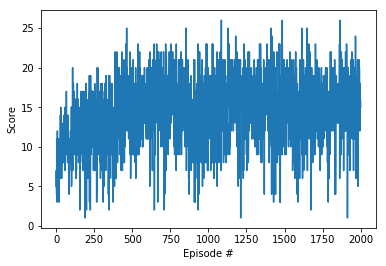

In [23]:
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 9. Watch the Smart Agent behave!

In the next code cell, I will load the trained weights from file to watch the smart/trained agent behave!

In [ ]:
# load the weights from file
# The "Best" average is NOT related to the the Best set of weights, since that last episode when we averaged
# and found out it was the best, might be actually a really bad (score) episode. Also the "Best" episode might be
# totally overfitted to a specific episode and the agent might not perform as well in a new episode.
# For the sake of the study we will load the last episode's weights that lead to the "Best" average.
agent.DQN_local.load_state_dict(torch.load('checkpoint_Best.pth'))

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment - NOT Training
    state = env_info.vector_observations[0]            # get the current state        
    for j in range(200):
        action = agent.act(state)                      # Act acording to Policy (eps = 0)
        env_info = env.step(action)[brain_name]        # send the action to the environment        
        done = env_info.local_done[0]                  # see if episode has finished
                
        if done:
            break 
            

When finished, you can close the environment.

In [ ]:
env.close()